In [1]:
# From PyG tutorial
# https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x, edge_index = x.to(device), edge_index.to(device)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

class GCN_SVI(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

        #### New lines for SVI ####
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on

    def append_to_layers_Xtilde(self, conv, x, edge_index = None):
        if self.on_training:
            x_tmp = x.detach().clone().to(device)
            if edge_index is None:
                self.layers_Xtilde.append(conv(x_tmp))
            else:
                self.layers_Xtilde.append(conv(x_tmp, edge_index))
    
    def append_to_layers_grad(self, x):
        if self.on_training:
            x.retain_grad()
            self.layers_grad.append(x)
    #### End #####

    def forward(self, x, edge_index):
        x, edge_index = x.to(device), edge_index.to(device)
        self.append_to_layers_Xtilde(self.conv1, x, edge_index)
        x = self.conv1(x, edge_index)
        x = x.relu()
        self.append_to_layers_grad(x)
        self.append_to_layers_Xtilde(self.conv2, x, edge_index)
        x = self.conv2(x, edge_index)
        self.append_to_layers_grad(x)
        return x

In [4]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def train_SVI():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))  # Compute the loss solely based on the training nodes.
    #### New lines for SVI ####
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward()  # Derive gradients.
    #### New lines for SVI ####
    loss_tilde = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().clone().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        loss_tilde += (Xlplus1*Xlplus1grad).sum() # No need to take mean any more, because loss is mean reduce
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    model.on_training = False
    #### End #####
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask].to(device)  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [5]:
epochs = 500
learning_rate = 0.05

In [6]:
# Train SGD
model = GCN(hidden_channels=64).to(device)
train_func = train
criterion = torch.nn.CrossEntropyLoss()
optim = 'SGD' # 'Adam' or 'SGD'
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
else:
    raise ValueError('optim must be either Adam or SGD')
train_loss_list = np.zeros(epochs)
test_acc_list = np.zeros(epochs)
for epoch in range(epochs):
    loss = train_func()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_loss_list[epoch] = loss
    test_acc = test()
    test_acc_list[epoch] = test_acc

SGD_results = {'train_loss_list': train_loss_list, 'test_acc_list': test_acc_list}

Epoch: 000, Loss: 1.9461
Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9458
Epoch: 003, Loss: 1.9456
Epoch: 004, Loss: 1.9454
Epoch: 005, Loss: 1.9453
Epoch: 006, Loss: 1.9451
Epoch: 007, Loss: 1.9450
Epoch: 008, Loss: 1.9449
Epoch: 009, Loss: 1.9448
Epoch: 010, Loss: 1.9447
Epoch: 011, Loss: 1.9446
Epoch: 012, Loss: 1.9446
Epoch: 013, Loss: 1.9445
Epoch: 014, Loss: 1.9444
Epoch: 015, Loss: 1.9444
Epoch: 016, Loss: 1.9443
Epoch: 017, Loss: 1.9442
Epoch: 018, Loss: 1.9442
Epoch: 019, Loss: 1.9441
Epoch: 020, Loss: 1.9441
Epoch: 021, Loss: 1.9440
Epoch: 022, Loss: 1.9440
Epoch: 023, Loss: 1.9440
Epoch: 024, Loss: 1.9439
Epoch: 025, Loss: 1.9439
Epoch: 026, Loss: 1.9438
Epoch: 027, Loss: 1.9438
Epoch: 028, Loss: 1.9438
Epoch: 029, Loss: 1.9437
Epoch: 030, Loss: 1.9437
Epoch: 031, Loss: 1.9437
Epoch: 032, Loss: 1.9436
Epoch: 033, Loss: 1.9436
Epoch: 034, Loss: 1.9436
Epoch: 035, Loss: 1.9435
Epoch: 036, Loss: 1.9435
Epoch: 037, Loss: 1.9435
Epoch: 038, Loss: 1.9434
Epoch: 039, Loss: 1.9434


In [7]:
# Train SVI
model = GCN_SVI(hidden_channels=64).to(device)
train_func = train_SVI
criterion = torch.nn.CrossEntropyLoss()
optim = 'SGD' # 'Adam' or 'SGD'
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
else:
    raise ValueError('optim must be either Adam or SGD')
train_loss_list = np.zeros(epochs)
test_acc_list = np.zeros(epochs)
for epoch in range(epochs):
    loss = train_func()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_loss_list[epoch] = loss
    test_acc = test()
    test_acc_list[epoch] = test_acc

SVI_results = {'train_loss_list': train_loss_list, 'test_acc_list': test_acc_list}

Epoch: 000, Loss: 1.9461
Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9460
Epoch: 003, Loss: 1.9460
Epoch: 004, Loss: 1.9460
Epoch: 005, Loss: 1.9459
Epoch: 006, Loss: 1.9459
Epoch: 007, Loss: 1.9459
Epoch: 008, Loss: 1.9459
Epoch: 009, Loss: 1.9458
Epoch: 010, Loss: 1.9458
Epoch: 011, Loss: 1.9458
Epoch: 012, Loss: 1.9458
Epoch: 013, Loss: 1.9458
Epoch: 014, Loss: 1.9457
Epoch: 015, Loss: 1.9457
Epoch: 016, Loss: 1.9457
Epoch: 017, Loss: 1.9457
Epoch: 018, Loss: 1.9457
Epoch: 019, Loss: 1.9456
Epoch: 020, Loss: 1.9456
Epoch: 021, Loss: 1.9456
Epoch: 022, Loss: 1.9456
Epoch: 023, Loss: 1.9455
Epoch: 024, Loss: 1.9455
Epoch: 025, Loss: 1.9455
Epoch: 026, Loss: 1.9454
Epoch: 027, Loss: 1.9454
Epoch: 028, Loss: 1.9454
Epoch: 029, Loss: 1.9454
Epoch: 030, Loss: 1.9453
Epoch: 031, Loss: 1.9453
Epoch: 032, Loss: 1.9453
Epoch: 033, Loss: 1.9453
Epoch: 034, Loss: 1.9452
Epoch: 035, Loss: 1.9452
Epoch: 036, Loss: 1.9452
Epoch: 037, Loss: 1.9451
Epoch: 038, Loss: 1.9451
Epoch: 039, Loss: 1.9451


In [12]:
# SVI-then-SGD
import numpy as np
# SGD_higher = np.where(SGD_results['train_loss_list']-SVI_results['train_loss_list']  >= 0)[0]
# print(SGD_higher)
# switch_epoch = SGD_higher[-1] + 1
switch_epoch = int(0.2*epochs)
print(f'Switch epoch from SVI to SGD = {switch_epoch}')
model = GCN_SVI(hidden_channels=64).to(device)
train_func = train_SVI
criterion = torch.nn.CrossEntropyLoss()
optim = 'SGD' # 'Adam' or 'SGD'
if optim == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optim == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
else:
    raise ValueError('optim must be either Adam or SGD')
train_loss_list = np.zeros(epochs)
test_acc_list = np.zeros(epochs)
for epoch in range(epochs):
    if switch_epoch <= epoch < switch_epoch + 1:
        print('### Switching from SVI to SGD at epoch {} ###'.format(epoch))
        import copy
        old_state_dict = copy.deepcopy(model.state_dict())
        train_func = train
        model = GCN(hidden_channels=64).to(device)
        model.load_state_dict(old_state_dict)
        if optim == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif optim == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            raise ValueError('optim must be either Adam or SGD')
    loss = train_func()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_loss_list[epoch] = loss
    test_acc = test()
    test_acc_list[epoch] = test_acc

SVI_switch_results = {'train_loss_list': train_loss_list, 'test_acc_list': test_acc_list}

Switch epoch from SVI to SGD = 100
Epoch: 000, Loss: 1.9461
Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9460
Epoch: 003, Loss: 1.9460
Epoch: 004, Loss: 1.9460
Epoch: 005, Loss: 1.9459
Epoch: 006, Loss: 1.9459
Epoch: 007, Loss: 1.9459
Epoch: 008, Loss: 1.9459
Epoch: 009, Loss: 1.9458
Epoch: 010, Loss: 1.9458
Epoch: 011, Loss: 1.9458
Epoch: 012, Loss: 1.9458
Epoch: 013, Loss: 1.9458
Epoch: 014, Loss: 1.9457
Epoch: 015, Loss: 1.9457
Epoch: 016, Loss: 1.9457
Epoch: 017, Loss: 1.9457
Epoch: 018, Loss: 1.9457
Epoch: 019, Loss: 1.9456
Epoch: 020, Loss: 1.9456
Epoch: 021, Loss: 1.9456
Epoch: 022, Loss: 1.9456
Epoch: 023, Loss: 1.9455
Epoch: 024, Loss: 1.9455
Epoch: 025, Loss: 1.9455
Epoch: 026, Loss: 1.9454
Epoch: 027, Loss: 1.9454
Epoch: 028, Loss: 1.9454
Epoch: 029, Loss: 1.9454
Epoch: 030, Loss: 1.9453
Epoch: 031, Loss: 1.9453
Epoch: 032, Loss: 1.9453
Epoch: 033, Loss: 1.9453
Epoch: 034, Loss: 1.9452
Epoch: 035, Loss: 1.9452
Epoch: 036, Loss: 1.9452
Epoch: 037, Loss: 1.9451
Epoch: 038, Los

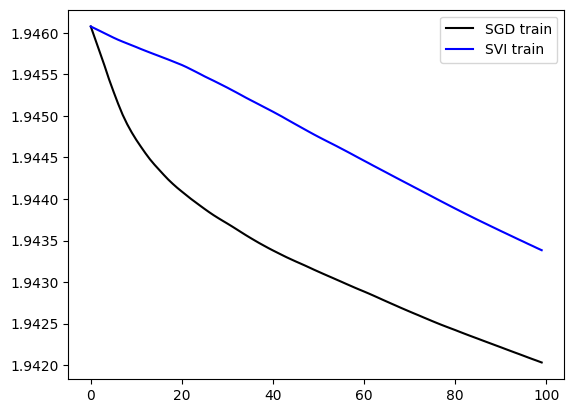

In [13]:
plt.plot(SGD_results['train_loss_list'][:100], label=f'{optim} train', color = 'black')
plt.plot(SVI_results['train_loss_list'][:100], label='SVI train', color='blue')
plt.legend()

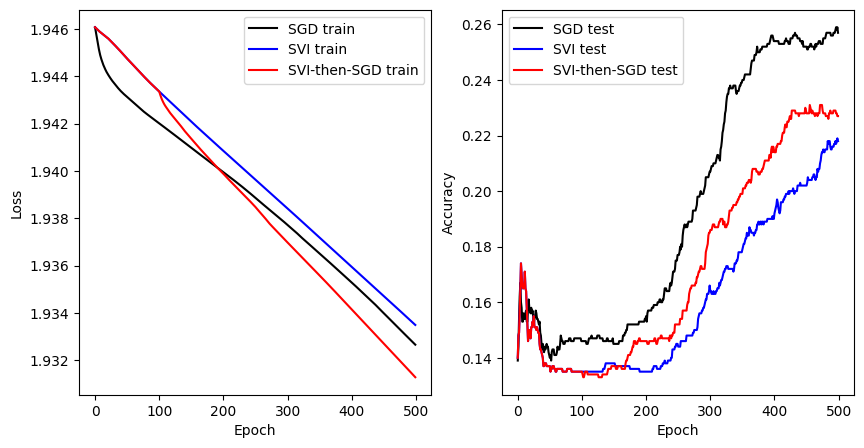

In [14]:
# 1 by 2 matplot subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(SGD_results['train_loss_list'], label=f'{optim} train', color = 'black')
ax[0].plot(SVI_results['train_loss_list'], label='SVI train', color='blue')
ax[0].plot(SVI_switch_results['train_loss_list'], label='SVI-then-SGD train', color='red')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(SGD_results['test_acc_list'], label=f'{optim} test', color = 'black')
ax[1].plot(SVI_results['test_acc_list'], label='SVI test', color='blue')
ax[1].plot(SVI_switch_results['test_acc_list'], label='SVI-then-SGD test', color='red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()